In [1]:
from google.cloud import vision
from google.cloud import storage
from PIL import Image
import numpy as np
import os, sys
import csv  
from io import BytesIO
from IPython import display
import csv

# Our scripts
from corrections import *
from image import * 
from handling import *

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"../guppies-test-4c48569421d8.json"

### Read all files from the google bucket. Can cycle through the files in this list and write results to the csv file.

In [2]:
# Read all JPG files. All images are in both .jpg and .nef formats, need to avoid duplicates.
all_files = ListAvaliableFiles("guppy_images")
all_jpg_files = [ x for x in all_files if "JPG" in x ]

# Read the random number array we will use to assign images.
# random_array = np.arange(len(all_jpg_files))
# np.random.shuffle(random_array)
# np.save('../Data/radom_array.npy', random_array)
random_array = np.load('../Data/radom_array.npy')

# Assign images.
Jordan_array = random_array[0:500]
Sunny_array = random_array[500:1000]

Jordan_files = []
Sunny_files = []

for index in Jordan_array:
    Jordan_files.append(all_jpg_files[index])

for index in Sunny_array:
    Sunny_files.append(all_jpg_files[index])

### Opens a file from the google bucket (or locally), crops it, reads it and corrects the output.


Initial label: B-FCA-4V7-01/21/13 
Corrected label: 1


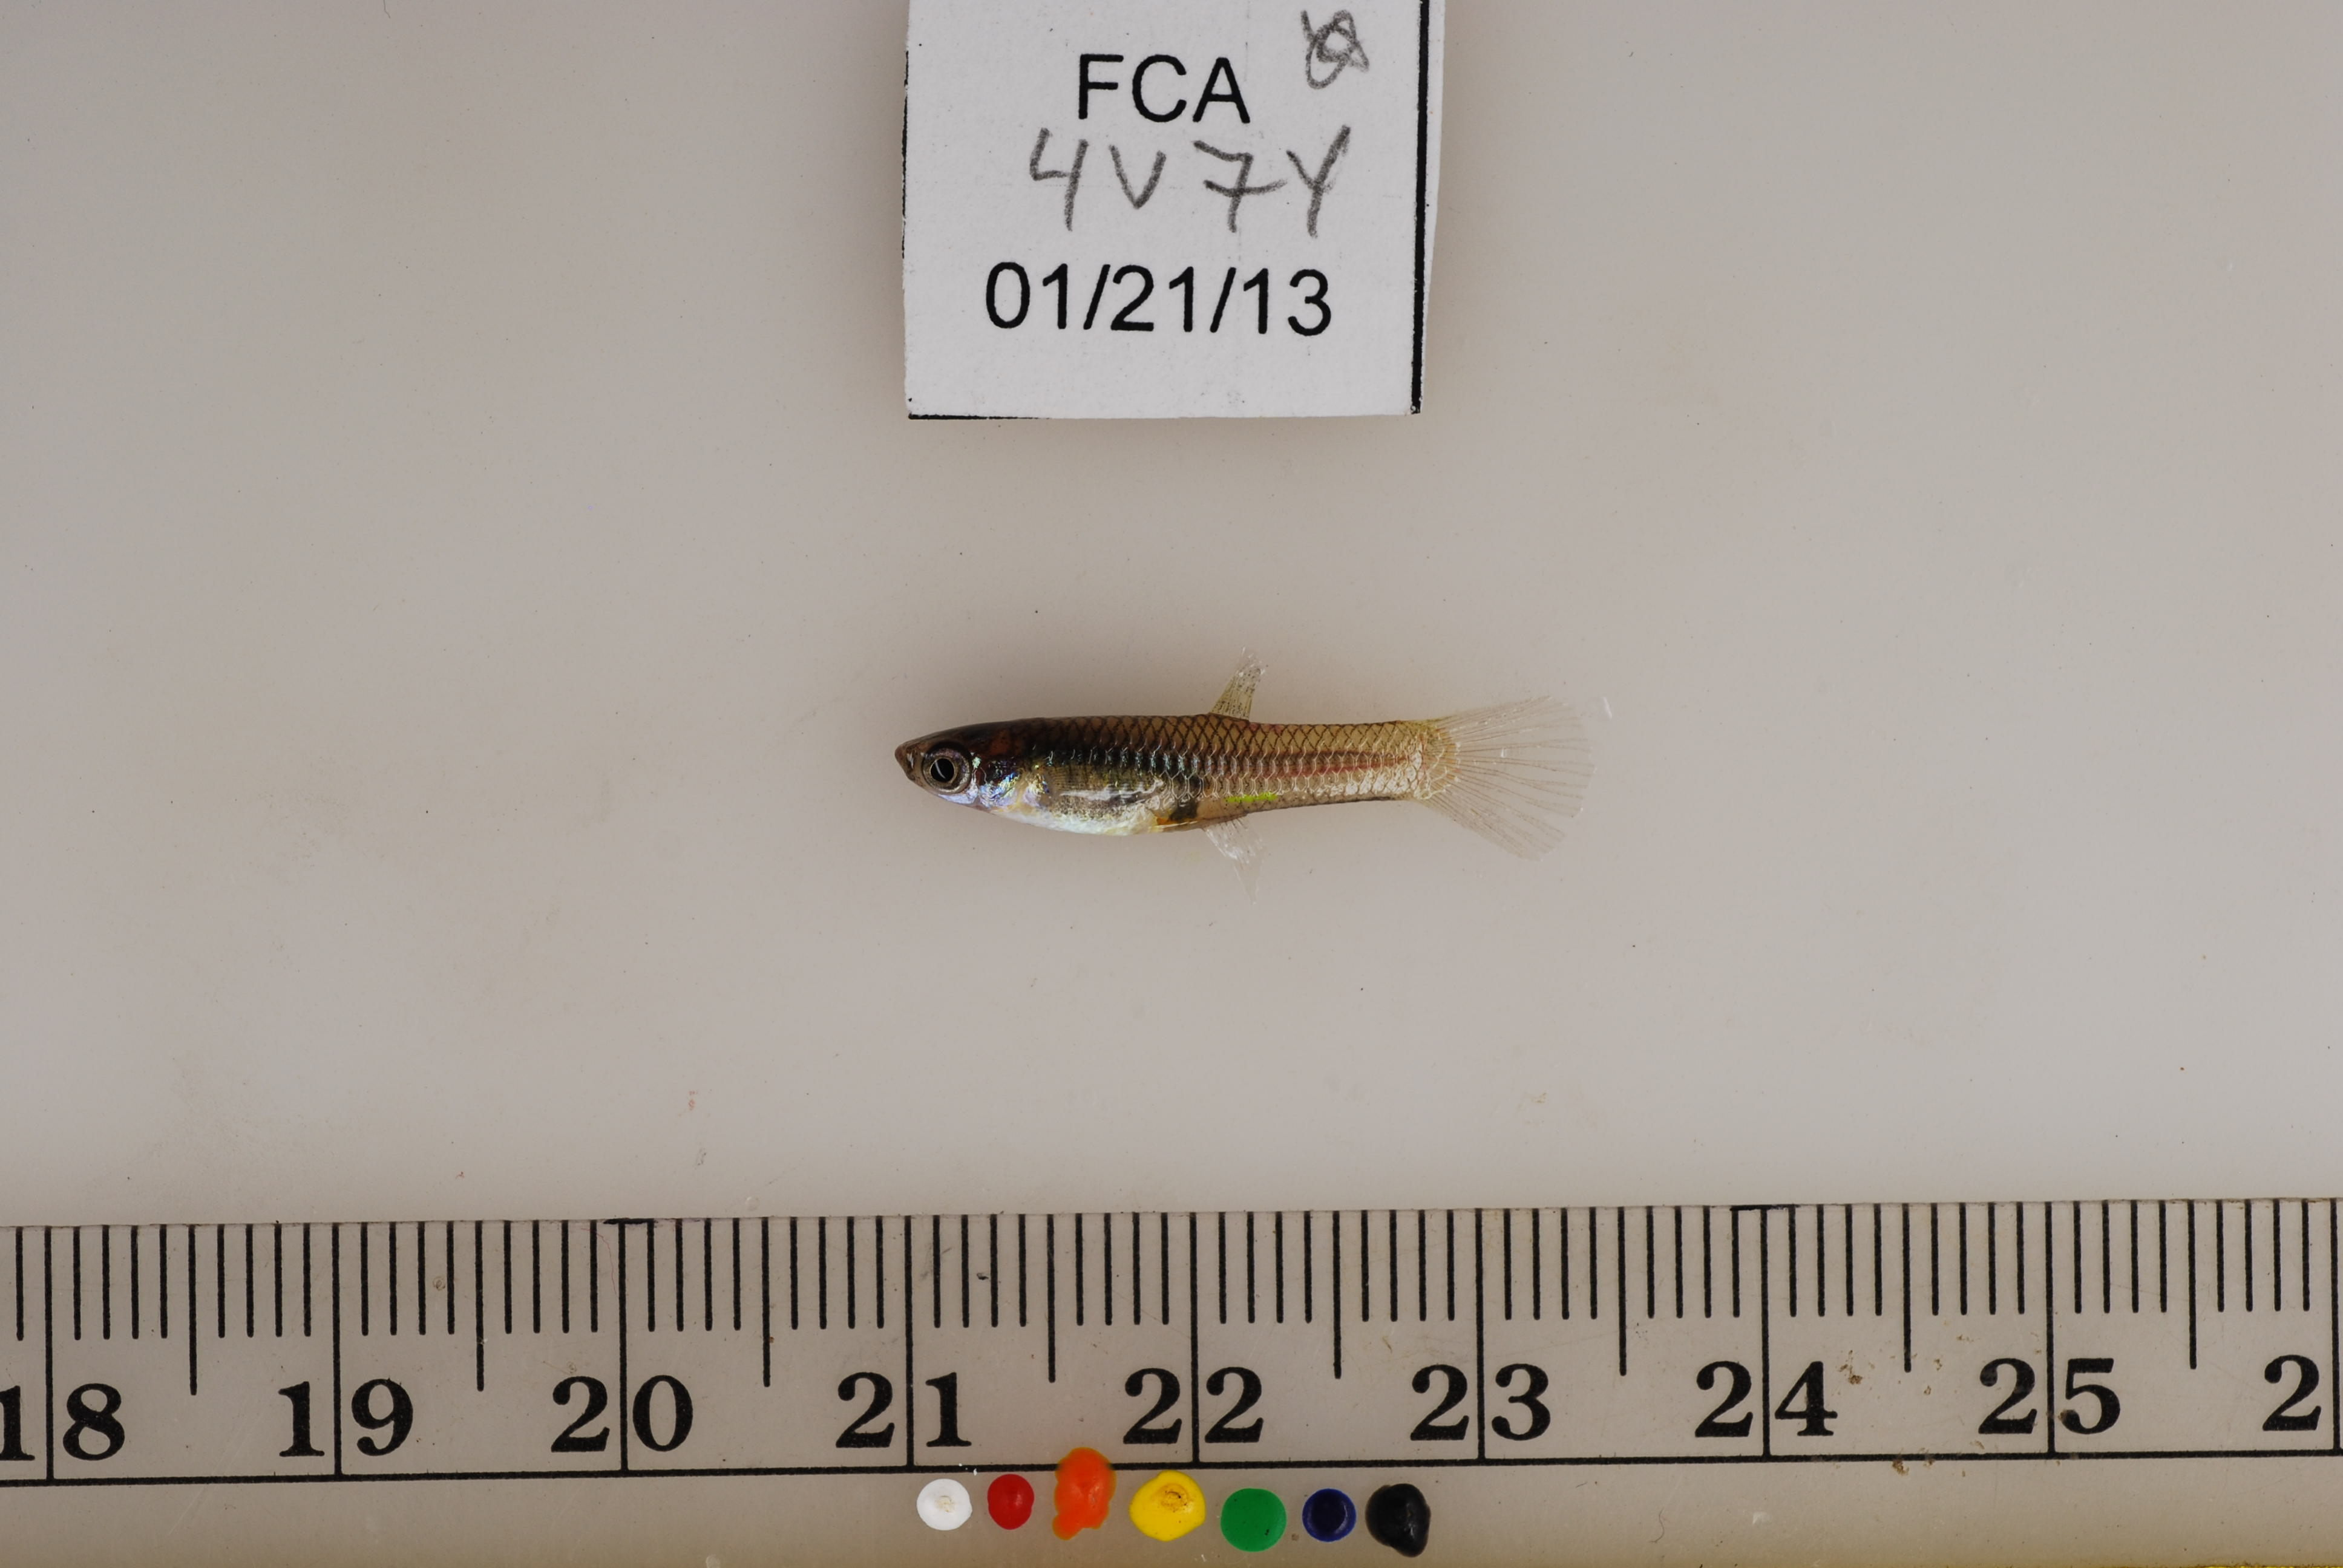

In [3]:
image, initial_label, corrected_label, word_confidences = \
    CorrectedLabel("1301/Caigual/21A/101NCD60/DSC_1122.JPG", "remote", verbose=False)

Image.open(image)

### Write filename, initial prediction, corrected prediction and the manually inputted truth to the truth.csv file for a set of file names.
The files have been randomised and split.

In [ ]:
with open('../Data/truth.csv', 'a') as f:
    writer = csv.writer(f)

    for file in Sunny_files:
        # Read the data and predict the label.
        image = RetreiveImage(file, verbose=False)
        cropped_image = CroppedImage(image, verbose=False)

        display.display(Image.open(cropped_image))
        display.clear_output(wait=True)

        initial_prediction = ReadImage(cropped_image, verbose=False)[0]
        corrected_prediction = FindErrors(initial_prediction)
    
        # Provide truth
        truth = input("Truth:")

        writer.writerow([file, initial_prediction, corrected_prediction, truth])

### Read through all cloud files and write filename, initial prediction and corrected prediction to the predictions.csv file.

In [ ]:
files = all_jpg_files
with open('../Data/predictions.csv', 'w') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(['filename', 'prediction', 'corrected'])

    for i, file in enumerate(files):    
        print(f'{i+1}/{len(files)}',end='\r')

        # Read the data
        image = RetreiveImage(file, verbose=False)
        cropped_image = CroppedImage(image, verbose=False)
        Image.open(cropped_image)
        initial_prediction = ReadImage(cropped_image, verbose=False)[0]
        corrected_prediction = FindErrors(initial_prediction)
        
        # write the data
        writer.writerow([all_files[i], initial_prediction, corrected_prediction])

now delete old file and rename new one.

### Some code to reanalyse and check the accuracy of the algorithm

In [ ]:
ReanalysePredictions("Truth", verbose=True)
correct_files, incorrect_files, invalid_files, character_confusions = \
    AccuracyCheck("/Users/jordan/Desktop/Guppies/Data/Truth_new.csv", verbose=False)

In [ ]:
np.save('../Data/incorrect_files.npy',np.array(incorrect_files))

make the confusion matrix

In [ ]:
true_chars = [X[0] for X in character_confusions]
true_chars_unique = np.unique(true_chars)
pred_chars = [X[1] for X in character_confusions]
pred_chars_unique = np.unique(pred_chars)

In [ ]:
confusion_matrix =  np.zeros((len(true_chars_unique), len(pred_chars_unique)))

for i in range(len(true_chars_unique)):
    for j in range(len(pred_chars_unique)):
        confusion_matrix[i,j] = np.sum((character_confusions[:,0] == true_chars_unique[i]) & (character_confusions[:,1] == pred_chars_unique[j]))

## Save the Confusion Matrix. This can be read by the code to directy choose the appropraite replacement.

In [ ]:
confusion_data = [confusion_matrix, true_chars_unique, pred_chars_unique]
np.save('../Data/ConfusionData/confusion_matrix.npy', confusion_data[0])
np.save('../Data/ConfusionData/confusion_true_chars.npy', confusion_data[1])
np.save('../Data/ConfusionData/confusion_pred_chars.npy', confusion_data[2])

In [ ]:
ConfusionMatrixPath = '../Data/ConfusionData'

confusion_matrix = np.load(ConfusionMatrixPath + '/confusion_matrix.npy')
true_chars_unique = np.load(ConfusionMatrixPath + '/confusion_true_chars.npy')
pred_chars_unique = np.load(ConfusionMatrixPath + '/confusion_pred_chars.npy')

import matplotlib.pyplot as plt
plt.imshow(confusion_matrix)
plt.yticks(np.arange(len(true_chars_unique)), true_chars_unique)
plt.xticks(np.arange(len(pred_chars_unique)), pred_chars_unique)
plt.colorbar()
plt.xlabel("Predicted Character")
plt.ylabel("True Character")

### Reads image from error file array in full verbose mode.

In [ ]:
files = incorrect_files

file = files[110]
image = RetreiveImage(file, verbose=True)

cropped_image = CroppedImage(image, verbose=True)
output_string, word_confidences = ReadImage(cropped_image, verbose=True)
label = FindErrors(output_string, verbose=True)
print("Initial label:", output_string,
      "\nCorrected label:", label)

In [ ]:
Image.open(image)

### Code used to combine truth_sunny and truth_Jordan files.

In [ ]:
# files = ['../Data/truth_Jordan.csv', '../Data/truth_sunny.csv']

# whole_file = []

# for file in files:
#     with open(file, 'r') as f:
#         filereader = csv.reader(f)
#         for row in filereader:
#             if row != []:
#                 whole_file.append(row)


# with open('../Data/Truth.csv', 'w') as Truth:
#     writer = csv.writer(Truth)
#     for row in whole_file:
#         writer.writerow(row)

### Code used to download all incorrect images.

In [ ]:
import random

truth_path = '../Data/Truth_new.csv'

error_files = ErrorFiles(truth_path)[0]
correct_files = ErrorFiles(truth_path)[2]
random.shuffle(correct_files)
correct_subset = correct_files[0:200]

for i, file in enumerate(error_files):
    # Initialise a client
    storage_client = storage.Client()
    # Create a bucket object for our bucket
    bucket = storage_client.get_bucket("guppy_images")
    # Create a blob object from the filepath
    blob = bucket.blob(file)
    # Download the file to a destination
    blob.download_to_filename('../Data/ErrorImages/%s' %(file.replace("/", "-")))
    print("%i/%i" %(i+1, len(error_files)))

for i, file in enumerate(correct_subset):
    # Initialise a client
    storage_client = storage.Client()
    # Create a bucket object for our bucket
    bucket = storage_client.get_bucket("guppy_images")
    # Create a blob object from the filepath
    blob = bucket.blob(file)
    # Download the file to a destination
    blob.download_to_filename('../Data/CorrectImages/%s' %(file.replace("/", "-")))
    print("%i/%i" %(i+1, len(correct_subset)))

In [ ]:
with open(f'../Data/{pred_file}_new.csv', 'r') as f:
    filereader = csv.reader(f)
    for n, row in enumerate(filereader):
        split = row[3].split('-')[1]
        if '0' in split:
            print(split, n)

Reanalysed predictions

Number Correct: 728 
Number Incorrect: 222 
Number Invalid: 50
Attempted % Correct: 0.7663157894736842
Total % Correct: 0.728
